**Тема проекта: Классификация и анализ тональности отзывов посетителей сети кофеен "Starbucks"**

Подготовили Романюков Егор и Леонович Матвей

**Постановка задачи**

У нас есть датасет с отзывами о кофейнях "Starbucks", каждый отзыв $x$ имеет признаки $(x_1, x_2, x_3, x_4, x_5, x_6)$, где $x_1$ - имя посетителя, оставившего отзыв, $x_2$ - местонахождение кофейни, $x_3$ - дата публикации отзыва, $x_4$ - оценка от 1 до 5, $x_5$ - сам отзыв, $x_6$ - приложенное к отзыву фото.

Признак $x_6$ есть у очень небольшого числа объектов (отзывов), также стоит отметить, что $x_4$ может равняться "N/A", а $x_5$ - "No Review Text", это стоит учесть при построении модели, например, сразу очевидно, что если для какого-то отзыва выполнено, например, что $x_4 =$ "N/A" и $x_5 =$ "No Review Text", то мы просто не будем добавлять этот отзыв ни в обучающую выборку, ни в тестовую, поскольку на этом нельзя ни обучаться, ни проверять качество работы модели.

Таким образом, мы будем по отзыву предсказывать оценку, выставленную посетителем, тем самым определяя, является отзыв позитивным, нейтральным или негативным,перед этим отбросив лишние данные.

#Датасет

Выгрузим датасет, уберём ненужные нам столбцы: имя посетителя, местонахождение кофейни, дату публикации отзыва и ссылку на приложенное к отзыву фото, оставляем только сам отзыв и оценку от 1 до 5.


In [262]:
import pandas as pd

data = pd.read_csv('reviews_data.csv')

data.drop('name', axis=1, inplace=True)
data.drop('location', axis=1, inplace=True)
data.drop('Date', axis=1, inplace=True)
data.drop('Image_Links', axis=1, inplace=True)

print(len(data))
print(data.head(5))

850
   Rating                                             Review
0     5.0  Amber and LaDonna at the Starbucks on Southwes...
1     5.0  ** at the Starbucks by the fire station on 436...
2     5.0  I just wanted to go out of my way to recognize...
3     5.0  Me and my friend were at Starbucks and my card...
4     5.0  I’m on this kick of drinking 5 cups of warm wa...


Удалим отзывы, где нет оценки или текста отзыва:

In [263]:
data = data[data['Review'] != 'No Review Text']
data_cleaned = data.dropna()

print(data_cleaned)

     Rating                                             Review
0       5.0  Amber and LaDonna at the Starbucks on Southwes...
1       5.0  ** at the Starbucks by the fire station on 436...
2       5.0  I just wanted to go out of my way to recognize...
3       5.0  Me and my friend were at Starbucks and my card...
4       5.0  I’m on this kick of drinking 5 cups of warm wa...
..      ...                                                ...
700     1.0  I ordered Via Starbucks coffee online. I recei...
701     3.0  My name is Ric **, I am journalist by professi...
702     1.0   The bagel was ice cold, not cut and not toasted.
703     1.0  In the morning of Monday, August 15, 2011, at ...
749     5.0  I found the coffee at Starbucks overrated and ...

[703 rows x 2 columns]


Получили те же 703 отзыва. Теперь разбиваем наш датасет на признаки и метки.

In [264]:
X = data_cleaned['Review']
y = data_cleaned['Rating']

Сейчас нам требуется превратить тексты наших отзывов в векторы, чтобы модель могла с этим работать, этим сейчас и займёмся:

In [265]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_bow = vectorizer.fit_transform(X)

print(X_bow.shape)

(703, 5509)


Теперь разделим датасет на тренировочную и тестовую выборки:

In [266]:
train_separator = 0.80  # percent of train tests

In [267]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=1-train_separator, random_state=27)
print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(562, 5509) 562
(141, 5509) 141


# Задача о классификации

Теперь переходим к обучению, будем использовать метод опорных векторов, о котором известно, что он хорошо показывает в себя в решении задач классификации:

In [268]:
from sklearn import svm

SVM_model = svm.SVC()

SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)

Оценим точность классификатора:

In [269]:
from sklearn.metrics import accuracy_score

print(accuracy_score(SVM_prediction, y_test))

0.6524822695035462


Accuracy получилась $\approx$ 65%, что нас не очень устраивает.

Теперь заранее обработаем текст, воспользовавшись, например, регулярками, и удалим стоп-слова.

In [270]:
import re

REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub('', line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(' ', line) for line in reviews]
    return reviews

X_cleaned = preprocess_reviews(X)

Пример случайного отзыва до и после обработки:

In [271]:
print(X[7])
print(X_cleaned[7])

Starbucks near me just launched new fall foods and beverages yesterday. By noon yesterday they were out of all new items. The fall launch is huge and many people look forward to it all year. Maybe if you don’t have enough product to last even a couple of days, push back the launch until you do? I was so happy to get the email that it had come out that I left work on my break to brighten my day and so very disappointed to get there at 12:30pm and find out that it was all gone. Please Starbucks, do better.
starbucks near me just launched new fall foods and beverages yesterday by noon yesterday they were out of all new items the fall launch is huge and many people look forward to it all year maybe if you don’t have enough product to last even a couple of days push back the launch until you do i was so happy to get the email that it had come out that i left work on my break to brighten my day and so very disappointed to get there at pm and find out that it was all gone please starbucks do 

Теперь удалим наши любимые стоп-слова:

In [272]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stop_words(texts):
  cleaned_texts = []
  for text in texts:
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    cleaned_texts.append(' '.join(filtered_words))
  return cleaned_texts

X_cleaned = remove_stop_words(X_cleaned)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Повторим векторизацию и обучение.

In [273]:
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X_cleaned)

X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=1-train_separator, random_state=27)

SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train)
SVM_prediction = SVM_model.predict(X_test)

print(accuracy_score(SVM_prediction, y_test))

0.6737588652482269


Теперь попробуем какой-нибудь другой метод векторизации, например, TF-IDF.

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = X_cleaned  # старый X нам больше не понадобится

vectorizer = TfidfVectorizer()
X_mtrx = vectorizer.fit_transform(X)

print(X_mtrx.shape)

(703, 5188)


Теперь поделим датасет на выборки train и test:

In [275]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_mtrx, y, test_size=1-train_separator, random_state=27)

print(X_train.shape, len(y_train))
print(X_test.shape, len(y_test))

(562, 5188) 562
(141, 5188) 141


Для обучения воспользуемся методом KNN:

In [276]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_train, y_train)

KNN_prediction = KNN_model.predict(X_test)
print(accuracy_score(KNN_prediction, y_test))

0.6808510638297872


In [277]:
print(KNN_prediction)

[2. 1. 1. 4. 2. 2. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 4. 5. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 3. 1. 1. 1. 1. 1. 1.
 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 4. 1. 1. 1. 1. 5. 1. 1. 1. 1. 2. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 5. 1. 2. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 5. 1.
 1. 5. 1. 1. 5. 5. 1. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 5. 1. 1. 5. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


Теперь попробуем LinearSVC для обучения

In [278]:
from sklearn.svm import LinearSVC

SVC_model = LinearSVC(dual='auto')
SVC_model.fit(X_train, y_train)
SVC_prediction = SVC_model.predict(X_test)
print(accuracy_score(SVC_prediction, y_test))

0.723404255319149


И LogisticRegression

In [279]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression(max_iter=200)
model_lr.fit(X_train, y_train)
lr_prediction = model_lr.predict(X_test)
print(accuracy_score(lr_prediction, y_test))

0.6524822695035462


**ФИКСИРУЕМ**

1. Предобработка текста позволила нам незначительно улучшить результат модели
2. Лучший результат около 72% выдали методы KNN и LinearSVC

Но мы хотим лучше

## *bonus*

*bonus* - попробуем разные соотношения train и test тестов

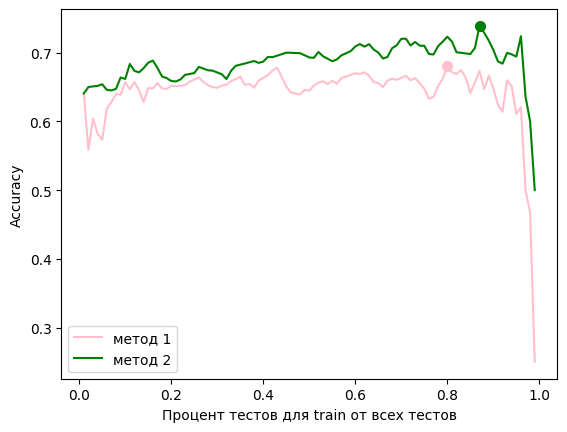

In [280]:
import matplotlib.pyplot as plt

x_plot = []
y_plot = []
maxers = [0, 0]
save = [0, 0]

for train_sep in range(1, 100):

  t_s = train_sep / 100
  X_train, X_test, y_train, y_test = train_test_split(X_mtrx, y, test_size=1-t_s, random_state=27)
  KNN_model = KNeighborsClassifier(n_neighbors=5)
  KNN_model.fit(X_train, y_train)
  KNN_prediction = KNN_model.predict(X_test)

  x_plot.append(t_s)
  y_plot.append(accuracy_score(KNN_prediction, y_test))
  if accuracy_score(KNN_prediction, y_test) > maxers[1]:
    maxers = [t_s, accuracy_score(KNN_prediction, y_test)]


plt.plot(x_plot, y_plot, color='pink', label='метод 1')
save = maxers
plt.xlabel('Процент тестов для train от всех тестов')
plt.ylabel('Accuracy')

####
####
####

x_plot = []
y_plot = []
maxers = [0, 0]
for train_sep in range(1, 100):

  t_s = train_sep / 100
  X_train, X_test, y_train, y_test = train_test_split(X_mtrx, y, test_size=1-t_s, random_state=27)
  SVC_model = LinearSVC(dual='auto')
  SVC_model.fit(X_train, y_train)
  SVC_prediction = SVC_model.predict(X_test)

  x_plot.append(t_s)
  y_plot.append(accuracy_score(SVC_prediction, y_test))
  if accuracy_score(SVC_prediction, y_test) > maxers[1]:
    maxers = [t_s, accuracy_score(SVC_prediction, y_test)]

plt.plot(x_plot, y_plot, color='green', label='метод 2')
plt.plot([save[0]], [save[1]], color='pink', marker='o', markersize=7)
plt.plot([maxers[0]], [maxers[1]], color='green', marker='o', markersize=7)
plt.legend(labels=['метод 1', "метод 2"])
plt.show()

Из интересных наблюдений:

1. База - нейросеть плохо учится, когда сильный перекос и тестов слишком много либо слишком мало
2. Лучшие показания зависят от использованных методов - разные методы дали разные пики.

Выводы? Давайте не мучать нейронку, она и так устала. А 80% - это золотой стандарт, вряд ли игра стоит свеч, и другой процент нам сильно лучше не сделает. Хотя возможно с этим тоже можно играться...

# Бинарная классификация

Упростим себе задачу, сведём её к бинарной классификации: будем по отзыву предсказывать, является он позитивным или негативным.

Пусть оценки 4 и 5 соответствуют позитивным отзывам, оценки ниже 4 соответствуют негативным отзывам.

1 будет означать, что отзыв pos, 0 будет означать, что отзыв neg.

In [281]:
data_cleaned.loc[data_cleaned['Rating'] <= 3, 'Rating'] = 0
data_cleaned.loc[data_cleaned['Rating'] >= 4, 'Rating'] = 1

In [282]:
X = data_cleaned['Review']
y = data_cleaned['Rating']
X = preprocess_reviews(X)
X = remove_stop_words(X)

Для векторизации используем IF-TDF

In [283]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_mtrx = vectorizer.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_mtrx, y, test_size=1-train_separator, random_state=27)

Рассмотрим точность трёх разных методов

In [284]:
from sklearn import svm

SVM_model = svm.SVC()
SVM_model.fit(X_train_bin, y_train_bin)
SVM_prediction = SVM_model.predict(X_test_bin)

from sklearn.metrics import accuracy_score

print(accuracy_score(SVM_prediction, y_test_bin))

0.8226950354609929


In [285]:
from sklearn.naive_bayes import GaussianNB

NB_model = GaussianNB()
NB_model.fit(X_train_bin.toarray(), y_train_bin)
NB_prediction = NB_model.predict(X_test_bin.toarray())
print(accuracy_score(NB_prediction, y_test_bin))

0.8085106382978723


In [286]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=5)
KNN_model.fit(X_train_bin, y_train_bin)
KNN_prediction = KNN_model.predict(X_test_bin)
print(accuracy_score(KNN_prediction, y_test_bin))

0.8581560283687943


**ФИКСИРУЕМ**

Как ни удивительно, задача бинарной классификации решается проще, добили точность до 85%